# Application of ML pipeline on dataset generated after MICE imputation of missing values in PIMA diabetes dataset:
- We will initialize the some classifier models with their default parameters and add them to a model list and apply on the dataset generated after MICE imputation of impossible zeros (disguised missing values) from the original PIMA diabetes dataset.

- When we fit aforesaid models a loop on the MICE imputed dataset ,we get the accuracy of the respective model using the “accuracy_score”

# Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

# Read the MICE Imputed dataset

In [2]:
#Loading the modified dataset (dataset that we generated in after MICE imputation of missing values in PIMA diabetes dataset
diabetes_df_mice = pd.read_csv("diabetes_df_mice.csv")

# Define X and y

In [3]:
X_mice = diabetes_df_mice[diabetes_df_mice.columns[:-1]]
y_mice = diabetes_df_mice.Outcome

# Scaling the data

In [4]:
scaler = StandardScaler()
X_mice_scaled = scaler.fit_transform(X_mice)

# Train-test split of data

In [5]:
# Splitting the dataset into training & test data
X_mice_train, X_mice_test, y_mice_train, y_mice_test = train_test_split(X_mice_scaled, y_mice, stratify=diabetes_df_mice.Outcome, random_state=0)


# ML Models

In [6]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [10]:
names = []
scores = []
for name, model in models:
    model.fit(X_mice_train, y_mice_train)
    y_pred_mice = model.predict(X_mice_test)
    scores.append(accuracy_score(y_mice_test, y_pred_mice))
    names.append(name)
tr_split_mice = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split_mice)

  Name     Score
0  KNN  0.708333
1  SVC  0.739583
2   LR  0.755208
3   DT  0.687500
4  GNB  0.765625
5   RF  0.734375
6   GB  0.770833


# Stratified K-Fold Cross-Validation

In [9]:
names = []
scores = []
for name, model in models:
    
    skfold = StratifiedKFold(n_splits=10) 
    score = cross_val_score(model, X_mice_scaled, y_mice, cv=skfold, scoring='accuracy').mean()
    
    names.append(name)
    scores.append(score)
skf_cross_val_mice = pd.DataFrame({'Name': names, 'Score': scores})
print(skf_cross_val_mice)

  Name     Score
0  KNN  0.747386
1  SVC  0.756511
2   LR  0.766934
3   DT  0.691422
4  GNB  0.756528
5   RF  0.756528
6   GB  0.769549


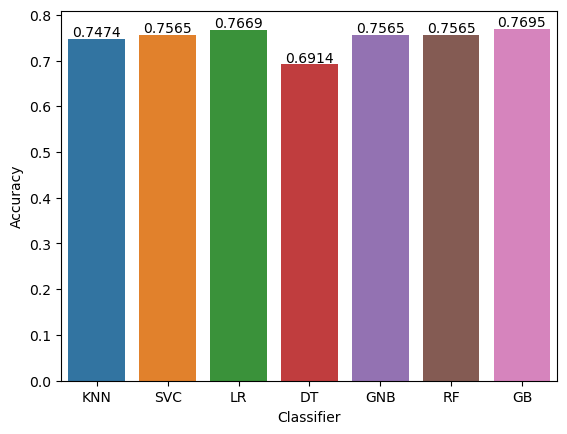

In [11]:
axis = sns.barplot(x = 'Name', y = 'Score', data = skf_cross_val_mice)
axis.set(xlabel='Classifier', ylabel='Accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

But after stratified K-fold cross validation, accuracy score of all models changed. At the baseline GB managed to achieve a classification accuracy of 76.95 %. This will be selected as the prime candidate for the next phases alongwith LR which is second best performing model having accuracy 76.69%.


# GradientBoostingClassifier- Feature selection

/Users/promilasharan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


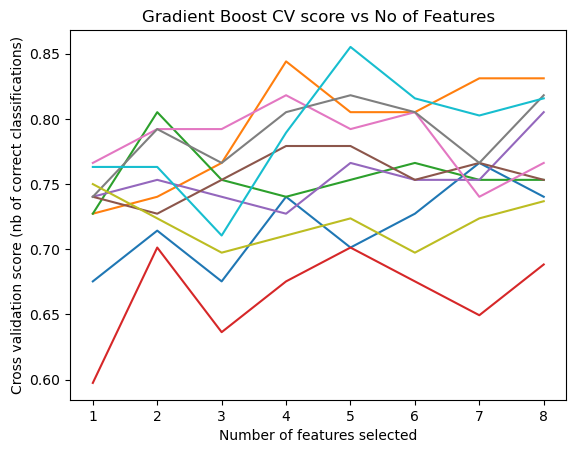

In [12]:
gb_model = GradientBoostingClassifier()
gb_rfecv = RFECV(estimator=gb_model, step=1, cv=skfold, scoring='accuracy')
gb_rfecv.fit(X_mice_scaled, y_mice)
plt.figure()
plt.title('Gradient Boost CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(gb_rfecv.grid_scores_) + 1), gb_rfecv.grid_scores_)
plt.show()

In [14]:
#We can see that having 5 input features generates the maximum accuracy.
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
feature_importance = list(zip(feature_names, gb_rfecv.support_))
new_features_mice = []
for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features_mice.append(value[0])
        
print(new_features_mice)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


here all of the original features are slected as important features so there is no point of proceeding further for model building

# Logistic regression- Feature selection

We can also study the 2nd best model (LR), to see if features selection process increases the model accuracy and if it would be better than GB after the process.


In [15]:
logreg_model = LogisticRegression()
rfecv = RFECV(estimator=logreg_model, step=1, cv=skfold, scoring='accuracy')
rfecv.fit(X_mice_scaled, y_mice)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=LogisticRegression(), scoring='accuracy')

/Users/promilasharan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


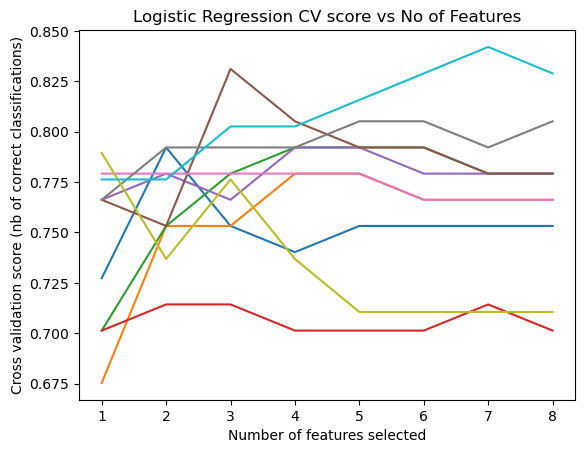

In [16]:
plt.figure()
plt.title('Logistic Regression CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [17]:
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
feature_importance = list(zip(feature_names, rfecv.support_))
new_features_mice_lr = []
for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features_mice_lr.append(value[0])
        
print(new_features_mice_lr)

['Pregnancies', 'Glucose', 'BMI']


In [19]:
new_features_mice_lr=['Pregnancies', 'Glucose', 'BMI']

df_X_mice= pd.DataFrame(X_mice_scaled)
df_X_mice.columns=diabetes_df_mice.columns[:-1]
df_X_mice.head(2)
df_X_mice[['Pregnancies', 'Glucose', 'BMI']]
df_X_mice.isnull().sum()
X_mice_new_lr = df_X_mice[new_features_mice_lr]

In [20]:
# Calculate accuracy scores

initial_score = cross_val_score(logreg_model, X_mice_scaled, y_mice, cv=skfold, scoring='accuracy').mean()
print("Initial accuracy : {} ".format(initial_score))
fe_score = cross_val_score(logreg_model, X_mice_new_lr, y_mice, cv=skfold, scoring='accuracy').mean()
print("Accuracy after Feature Selection : {} ".format(fe_score))

Initial accuracy : 0.7669343814080657 
Accuracy after Feature Selection : 0.7747778537252221 


We can do a comparison of the LR model with original features and the RFECV selected features to see if there is an improvement in the accuracy scores. 
We can conclude that there is slight increase in accuracy of LR classifier (from 76.69 % to 77.47%) after taking into consideration the above mentioned three predictors. In other words, we can also infer that there is slight difference in accuracy of Logistic regression classifier with original features & with RFECV selected features implying that remaining five features are not contributing significantly for prediction of response variable, i.e., Outcome.
In fact, its accuracy become more than GB. So we will proceed with LR for Hyperparameter Tuning

# Hyperparameter Tuning of Logistic Regression Classifier

We provide a list of grids with compatible parameters to help fine tune the Logistic Regression model. Through trial and error the following compatible parameters were found. Through trial and error, the following compatible parameters were found.


In [21]:
# Specify parameters
c_values = list(np.arange(1, 10))
param_grid = [
    {'C': c_values, 'penalty': ['l1'], 'solver' : ['liblinear'], 'multi_class' : ['ovr']},
    {'C': c_values, 'penalty': ['l2'], 'solver' : ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class' : ['ovr']}
]

We then fit the data to GridSearchCV, which performs k-fold cross-validation on the data for each combination of the parameters

In [22]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=skfold, scoring='accuracy')
grid.fit(X_mice_new_lr, y_mice)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid=[{'C': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'multi_class': ['ovr'], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'multi_class': ['ovr'], 'penalty': ['l2'],
                          'solver': ['liblinear', 'newton-cg', 'lbfgs']}],
             scoring='accuracy')

In [23]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 1, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression(C=1, multi_class='ovr', penalty='l1', solver='liblinear')


In [24]:
logreg_new = LogisticRegression(C=1, multi_class='ovr', penalty='l1', solver='liblinear')
initial_score = cross_val_score(logreg_new, X_mice_new_lr, y_mice, cv=skfold, scoring='accuracy').mean()
print("Final accuracy : {} ".format(initial_score))

Final accuracy : 0.7747778537252221 


We can see that accuracy doesn't increase even after hyperparameter tuning. We manage to achieve a classification accuracy of 77.48% which we can say is quite good.